In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from model import LeNet
from dataloader import MNISTDataLoader
from dataloader_weightedsample import MNISTDataLoaderWeightedSample

Starting train data count =  60000
Starting train data dist =  [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
Starting validation data count =  3000
Starting validation data dist =  [297, 329, 312, 300, 294, 276, 270, 337, 297, 288]
New train data count 1 =  54210
New train data dist 1 =  [5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421]
New train data count 2 =  29811
New train data dist 2 =  [5421, 4878, 4336, 3794, 3252, 2710, 2168, 1626, 1084, 542]
Corrupted test dist =  [980, 1135, 1701, 1010, 982, 223, 958, 1028, 974, 1009]


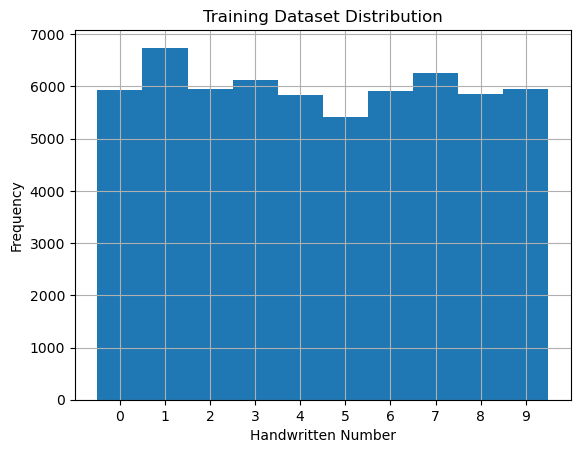

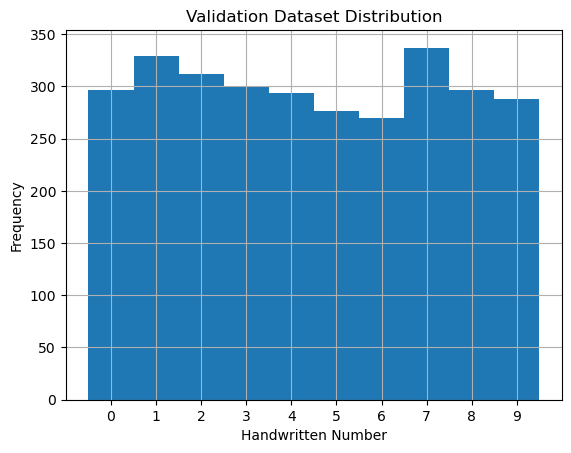

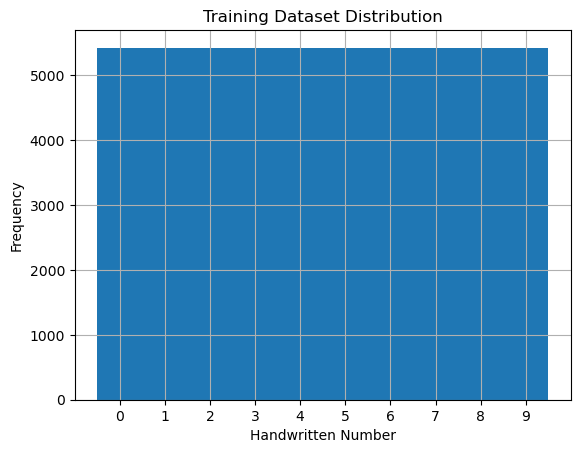

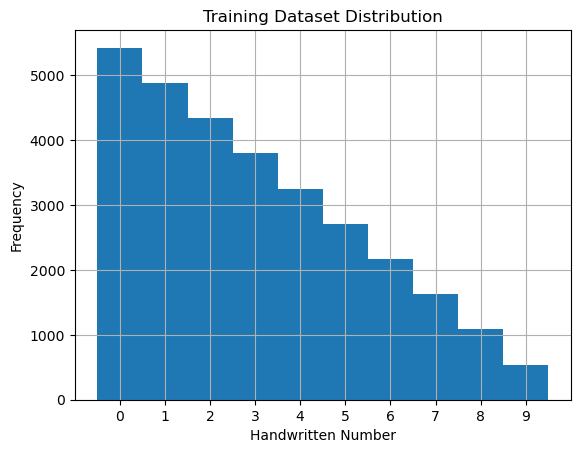

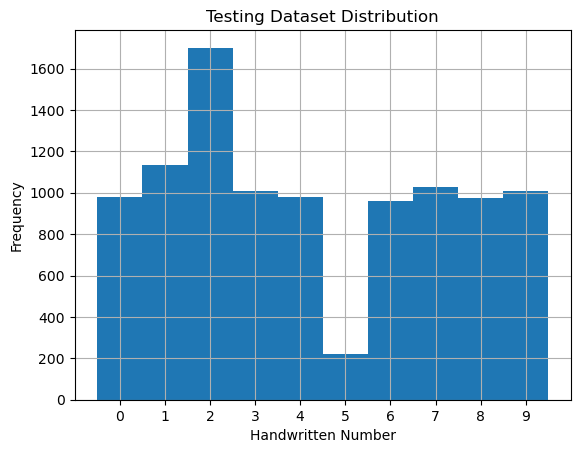

In [18]:

# Test functionality of MNISTDataLoader class

my_data = MNISTDataLoader()

# Starting training data distribution
print("Starting train data count = ", my_data.get_num("train"))
print("Starting train data dist = ", my_data.get_curr_dist("train"))
my_data.plot_dist(dataset="train")

# Initial Validation dataset
print("Starting validation data count = ", my_data.get_num("valid"))
print("Starting validation data dist = ", my_data.get_curr_dist("valid"))
my_data.plot_dist(dataset="valid")

# Sampling 1
my_dist = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
my_data.sample_bias(my_dist, dataset="train", dist_is_freq=True)
print("New train data count 1 = ", my_data.get_num("train"))
print("New train data dist 1 = ", my_data.get_curr_dist("train"))
my_data.plot_dist(dataset="train")

# Sampling 2
my_dist = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
my_data.sample_bias(my_dist, dataset="train", dist_is_freq=True)
print("New train data count 2 = ", my_data.get_num("train"))
print("New train data dist 2 = ", my_data.get_curr_dist("train"))
my_data.plot_dist(dataset="train")

# Corrupt testing data
my_data.corrupt_targets(5, 2, freq_corrupt=0.75, dataset="test")
my_data.plot_dist(dataset="test")
print("Corrupted test dist = ", my_data.get_curr_dist("test"))

[5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 542]
tensor([0, 0, 4, 9, 9, 3, 3, 8, 4, 0, 5, 3, 4, 2, 8, 6, 8, 9, 4, 2, 1, 2, 8, 8,
        6, 8, 1, 3, 3, 4, 9, 7, 9, 9, 0, 2, 8, 1, 3, 3, 8, 7, 5, 3, 6, 1, 2, 8,
        3, 5])
tensor(6)
tensor([6, 5, 0, 3, 8, 0, 2, 4, 3, 4, 3, 9, 3, 4, 2, 0, 0, 4, 6, 6, 0, 5, 4, 0,
        0, 4, 1, 5, 9, 0, 8, 3, 8, 1, 7, 7, 9, 1, 7, 8, 5, 4, 7, 4, 1, 3, 7, 3,
        1, 4])
tensor(3)
tensor([7, 0, 9, 7, 4, 7, 2, 8, 0, 0, 9, 2, 6, 9, 2, 0, 2, 8, 2, 6, 0, 3, 8, 5,
        7, 8, 2, 8, 9, 7, 1, 6, 6, 9, 2, 7, 9, 2, 1, 5, 6, 2, 4, 1, 6, 3, 1, 4,
        6, 3])
tensor(6)
tensor([7, 5, 8, 4, 3, 6, 1, 6, 9, 5, 4, 6, 2, 2, 3, 6, 1, 5, 5, 3, 6, 9, 8, 5,
        2, 8, 4, 7, 0, 3, 6, 0, 8, 5, 3, 2, 6, 6, 8, 2, 8, 5, 0, 4, 4, 9, 0, 7,
        8, 7])
tensor(3)
tensor([0, 4, 1, 2, 2, 0, 6, 8, 7, 0, 0, 1, 2, 1, 8, 5, 2, 7, 1, 2, 1, 4, 0, 1,
        7, 0, 9, 1, 1, 5, 7, 7, 4, 7, 1, 0, 2, 7, 0, 9, 9, 2, 7, 8, 5, 9, 9, 8,
        5, 2])
tensor(5)


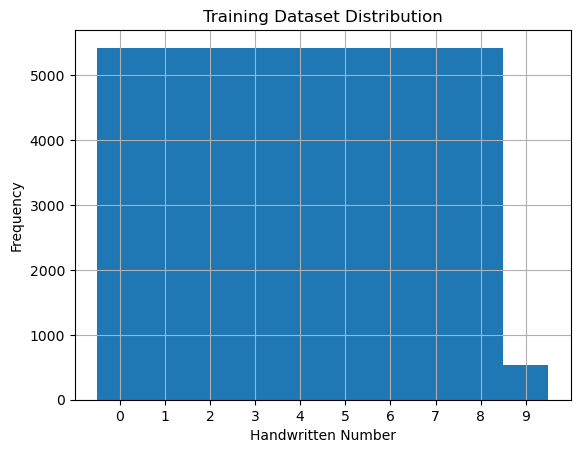

In [15]:
# Test functionality of MNISTDataLoaderWeightedSample class

# Force 10% representation for 9's class but oversample 9's by a factor of 10
desired_sample_distribution = [100, 100, 100, 100, 100, 100, 100, 100, 100, 10]
train_sample_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0]
data_loader = MNISTDataLoaderWeightedSample(desired_sample_distribution,
                                            train_sample_weights,
                                            batch_size_train=50
                                            )

# Show training distribution
print(data_loader.get_curr_dist(dataset="train"))
data_loader.plot_dist(dataset="train")

# Print training batch data and calculation representation of 9's (should be around 5 per batch)
for _ in range(5):
    X_f, y_f = next(iter(data_loader.train_dataloader))
    print(y_f)
    print(torch.sum(y_f==9))


In [8]:
## Test learning to reweight model
# from main import Reweighting


# torch.backends.cudnn.enabled = False
# torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device = ", device)

class Reweighting():
    def __init__(self, network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader):
        self.network = network.requires_grad_(requires_grad=True)
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.criterion_mean = criterion_mean
        self.gradient_network = None

    def train(self):
        # X_g = LeNet5()
        # print("Starting training...")
        X_g, y_g = next(iter(self.valid_loader))
        X_g = X_g.to(device)
        y_g = y_g.to(device)

        y_f_hat = torch.empty(1)
        y_f_hat = y_f_hat.to(device)

        theta_tp1 = self.network.state_dict()
        for epoch in range(self.hyperparameters['n_epochs']):
            self.network.train()

            self.gradient_network = LeNet()
            self.gradient_network.load_state_dict(theta_tp1)

            # get batch of data from train_loader
            X_f, y_f = next(iter(self.train_loader))
            X_f = X_f.to(device)
            y_f = y_f.to(device)

            # Line 4
            y_f_hat = self.gradient_network(X_f)
            
            # Line 5
            epsilon = torch.zeros(y_f.size(), requires_grad=True)
            epsilon = epsilon.to(device)

            Costs = self.criterion(y_f_hat, y_f)
            l_f = torch.sum(torch.mul(Costs, epsilon))

            # Line 6
            grad_t = torch.autograd.grad(outputs=l_f, inputs=self.gradient_network.params(), create_graph=True)
            

            # Line 7: manually update the weights of the validation network
            lr = self.hyperparameters['learning_rate']
            self.gradient_network.update_params_SGD_step(lr, grad_t)

            # Line 8
            # Model has theta_hat
            y_g_hat = self.gradient_network(X_g)

            # Line 9
            l_g = self.criterion_mean(y_g_hat, y_g)

            # Line 10
            grad_epsilon = torch.autograd.grad(l_g, epsilon, only_inputs=True)[0]

            # Line 11
            w_tilde = torch.clamp(-grad_epsilon, min=0)

            if torch.sum(w_tilde) != 0:
                w = w_tilde / torch.sum(w_tilde)
            else:
                w = w_tilde

            # Line 12
            y_f_hat = self.network(X_f)
            Costs = self.criterion(y_f_hat, y_f)
            l_f_hat = torch.sum(torch.mul(Costs, w))

            self.optimizer.zero_grad()

            # Line 13
            l_f_hat.backward()

            # Line 14
            self.optimizer.step()
            # break

            theta_tp1 = self.network.state_dict()

            if (epoch % self.hyperparameters['log_interval'] == 0):
                self.network.eval()

                acc = []
                for itr,(test_img, test_label) in enumerate(self.valid_loader):
                    prediction = self.network(test_img.to(device)).detach().cpu().numpy()
                    prediction = np.argmax(prediction, axis=1)
                    # print(prediction)
                    # print(test_label.detach().numpy())
                    tmp = (prediction == test_label.detach().numpy())
                    tmp = tmp*1
                    acc.append(tmp)

                accuracy = np.concatenate(acc).mean()
                # print("validation loss ", np.round(accuracy*100,2))
    def test(self):
        self.network.eval()

        acc = []
        for itr,(test_img, test_label) in enumerate(self.test_loader):
            prediction = self.network(test_img.to(device)).detach().cpu().numpy()
            prediction = np.argmax(prediction, axis=1)
            tmp = (prediction == test_label.detach().numpy())
            tmp = tmp*1
            acc.append(tmp)

        accuracy = np.concatenate(acc).mean()
        return np.round(accuracy*100,2)

# number of epoch and log interval reduced for testing
hyperparameters = {
    'n_epochs' : 10,
    'batch_size_train' : 100,
    'batch_size_valid' : 10,
    'batch_size_test' : 1000,
    'learning_rate' : 1e-3,
    'momentum' : 0.5,
    'log_interval' : 2
}

network = LeNet()

criterion = nn.CrossEntropyLoss(reduction='none')
criterion_mean = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.SGD(network.params(),
                        lr=hyperparameters['learning_rate'],
                        momentum=hyperparameters['momentum'])
# Load the data
data_loader = MNISTDataLoader(validation_ratio=0.05,
                            batch_size_train=hyperparameters['batch_size_train'],
                            batch_size_valid=hyperparameters['batch_size_valid'],
                            batch_size_test=hyperparameters['batch_size_test'])

# 10% representation by 9's class in training data
desired_sample_distribution = [100, 100, 100, 100, 100, 100, 100, 100, 100, 10]
data_loader.sample_bias(desired_sample_distribution, dataset="train")


train_loader = data_loader.train_dataloader
valid_loader = data_loader.valid_dataloader
test_loader = data_loader.test_dataloader


our_model = Reweighting(network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader)

start_accuracy = our_model.test()
print("Starting accuracy = ", start_accuracy)

our_model.train()

end_accuracy = our_model.test()
print("Ending accuracy = ", end_accuracy)



device =  cuda:0
Starting accuracy =  10.73
Ending accuracy =  12.33


In [15]:
## Test control model
# from main import Reweighting


# torch.backends.cudnn.enabled = False
# torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device = ", device)

class NoReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.train_loader
        self.test_loader = test_loader

    def train(self):
        # Train the network
        for epoch in range(hyperparameters['n_epochs']):
            self.network.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.to(device)
                target = target.to(device)

                self.optimizer.zero_grad()
                output = self.network(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                # if batch_idx % hyperparameters['log_interval'] == 0:
                #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #         epoch, batch_idx * len(data), len(train_loader.dataset),
                #         100. * batch_idx / len(train_loader), loss.item()))


    def test(self):
        test_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            self.network.eval()
            output = self.network(data.to(device)).cpu()
            test_loss += self.criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        # print('\nTest set: \nAvg. loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
        #     test_loss, correct, len(test_loader.dataset),
        #     100.0 * correct / len(test_loader.dataset)))
        
        return (100.0 * correct / len(test_loader.dataset)).item()

# number of epoch and log interval reduced for testing
hyperparameters = {
    'n_epochs' : 2,
    'batch_size_train' : 100,
    'batch_size_valid' : 10,
    'batch_size_test' : 1000,
    'learning_rate' : 1e-3,
    'momentum' : 0.5,
    'log_interval' : 1
}

network = LeNet()

criterion = nn.CrossEntropyLoss(reduction='none')
criterion_mean = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.SGD(network.params(),
                        lr=hyperparameters['learning_rate'],
                        momentum=hyperparameters['momentum'])
# Load the data
data_loader = MNISTDataLoader(validation_ratio=0.05,
                            batch_size_train=hyperparameters['batch_size_train'],
                            batch_size_valid=hyperparameters['batch_size_valid'],
                            batch_size_test=hyperparameters['batch_size_test'])

# 10% representation by 9's class in training data
desired_sample_distribution = [100, 100, 100, 100, 100, 100, 100, 100, 100, 10]
data_loader.sample_bias(desired_sample_distribution, dataset="train")


train_loader = data_loader.train_dataloader
valid_loader = data_loader.valid_dataloader
test_loader = data_loader.test_dataloader


our_model = NoReweighting(network, hyperparameters, criterion_mean, optimizer, train_loader, test_loader)

start_accuracy = our_model.test()
print("Starting accuracy = ", start_accuracy)

our_model.train()

end_accuracy = our_model.test()
print("Ending accuracy = ", end_accuracy)


device =  cuda:0
Starting accuracy =  9.569999694824219
Ending accuracy =  18.65999984741211


In [16]:
## Test oversampling model
# from main import Reweighting


# torch.backends.cudnn.enabled = False
# torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device = ", device)

class NoReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.train_loader
        self.test_loader = test_loader

    def train(self):
        # Train the network
        for epoch in range(hyperparameters['n_epochs']):
            self.network.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.to(device)
                target = target.to(device)

                self.optimizer.zero_grad()
                output = self.network(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                # if batch_idx % hyperparameters['log_interval'] == 0:
                #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #         epoch, batch_idx * len(data), len(train_loader.dataset),
                #         100. * batch_idx / len(train_loader), loss.item()))


    def test(self):
        test_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(self.test_loader):
            self.network.eval()
            output = self.network(data.to(device)).cpu()
            test_loss += self.criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        # print('\nTest set: \nAvg. loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
        #     test_loss, correct, len(test_loader.dataset),
        #     100.0 * correct / len(test_loader.dataset)))
        
        return (100.0 * correct / len(self.test_loader.dataset)).item()

# number of epoch and log interval reduced for testing
hyperparameters = {
    'n_epochs' : 10,
    'batch_size_train' : 100,
    'batch_size_valid' : 10,
    'batch_size_test' : 1000,
    'learning_rate' : 1e-3,
    'momentum' : 0.5,
    'log_interval' : 2
}

network = LeNet()

criterion = nn.CrossEntropyLoss(reduction='none')
criterion_mean = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.SGD(network.params(),
                        lr=hyperparameters['learning_rate'],
                        momentum=hyperparameters['momentum'])

# Load the data
# 10% representation by 9's class in training data
desired_sample_distribution = [100, 100, 100, 100, 100, 100, 100, 100, 100, 10]
train_sample_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1/(10.0/100)]
data_loader = MNISTDataLoaderWeightedSample(desired_sample_distribution,
                                    train_sample_weights,
                                    validation_ratio=0.05,
                                    batch_size_train=hyperparameters['batch_size_train'],
                                    batch_size_valid=hyperparameters['batch_size_valid'],
                                    batch_size_test=hyperparameters['batch_size_test'],
                                    shuffle=True)

train_loader = data_loader.train_dataloader
valid_loader = data_loader.valid_dataloader
test_loader = data_loader.test_dataloader

our_model = NoReweighting(network, hyperparameters, criterion_mean, optimizer, train_loader, test_loader)

start_accuracy = our_model.test()
print("Starting accuracy = ", start_accuracy)

our_model.train()

end_accuracy = our_model.test()
print("Ending accuracy = ", end_accuracy)

device =  cuda:0
Starting accuracy =  6.75
Ending accuracy =  6.869999885559082
